# Método 2: Features baseadas em embeddings e TF-IDF + Multi-layer perceptron com Torch

OBS: Rodar com GPU

Carregando dataset
Qtd treino: 50942
Qtd teste: 12736
Montando TFIDF
Carregando bert
Gerando embeddings dos textos, vai demorar um pouco, pode ir pegar um café ou um pão com manteiga...
Concatenando TFIDF e embeddigns
Começando o treino
Epoca 1/10 - Perda treino: 0.2724 | Acc: 0.8841 | Prec: 0.9048 | Rec: 0.8320 | F1: 0.8669 | AUC: 0.9588 | MCC: 0.7667 || Perda teste: 0.1308 | Acc: 0.9508 | Prec: 0.9428 | Rec: 0.9493 | F1: 0.9460 | AUC: 0.9901 | MCC: 0.9009
Epoca 2/10 - Perda treino: 0.1066 | Acc: 0.9610 | Prec: 0.9569 | Rec: 0.9572 | F1: 0.9570 | AUC: 0.9930 | MCC: 0.9213 || Perda teste: 0.0972 | Acc: 0.9631 | Prec: 0.9503 | Rec: 0.9694 | F1: 0.9597 | AUC: 0.9943 | MCC: 0.9258
Epoca 3/10 - Perda treino: 0.0761 | Acc: 0.9726 | Prec: 0.9697 | Rec: 0.9699 | F1: 0.9698 | AUC: 0.9963 | MCC: 0.9447 || Perda teste: 0.0901 | Acc: 0.9662 | Prec: 0.9518 | Rec: 0.9747 | F1: 0.9631 | AUC: 0.9953 | MCC: 0.9321
Epoca 4/10 - Perda treino: 0.0611 | Acc: 0.9782 | Prec: 0.9751 | Rec: 0.9769 | F1: 0.976

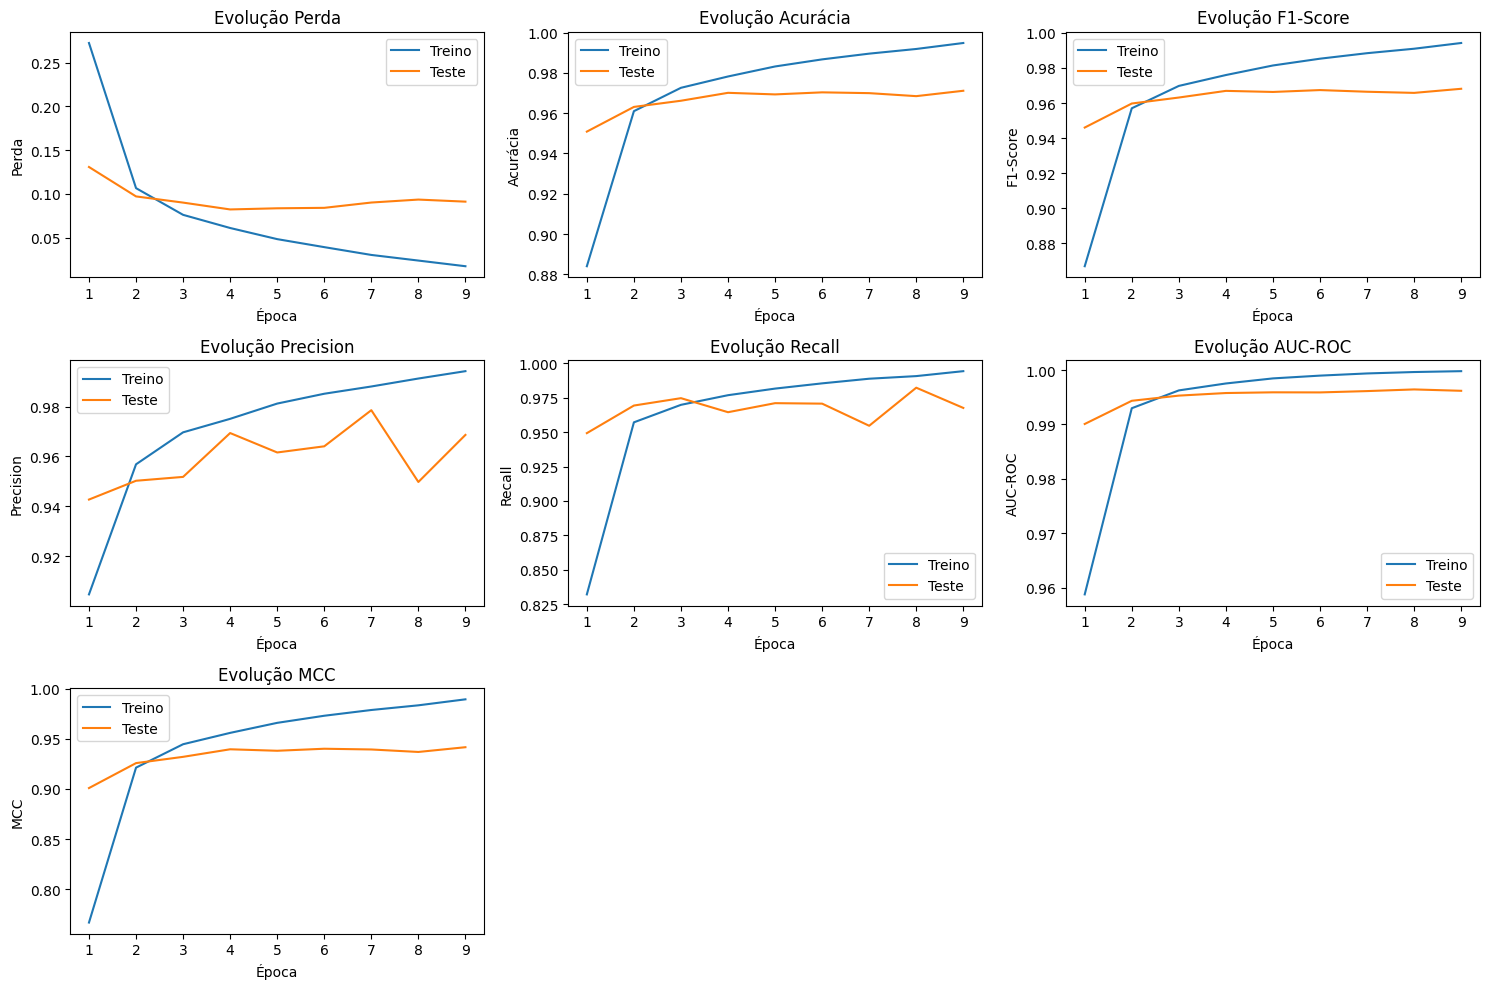

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, matthews_corrcoef, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModel

BATCH_SIZE = 64
EPOCHS = 10
LR = 1e-4
PATIENCE = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Carregando dataset")
df = pd.read_csv("dataset/WELFake_Dataset.csv")
df.drop_duplicates(subset=["title", "text", "label"], inplace=True)

# Tem valores faltando :(
df["title"] = df["title"].fillna("")
df["text"] = df["text"].fillna("")

df["conteudo"] = df["title"] + " " + df["text"]

x_treino, x_teste, y_treino, y_teste = train_test_split(df["conteudo"], df["label"], test_size=0.2, random_state=1234567890, stratify=df["label"])

print(f"Qtd treino: {len(x_treino)}")
print(f"Qtd teste: {len(x_teste)}")

print("Montando TFIDF")
# O ideal seria usar umas 25k features, mas minha GPUzinha de 4GB não aguenta :'(
tfidf = TfidfVectorizer(max_df=0.7, max_features=5000, ngram_range=(1, 2), sublinear_tf=True)

x_treino_tfidf = tfidf.fit_transform(x_treino)
x_teste_tfidf = tfidf.transform(x_teste)

print("Carregando bert")
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
bert_model = AutoModel.from_pretrained("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2").to(DEVICE)
bert_model.eval()

def pegar_embeddings_bert(texts, batch_size=32):
	# Obs: função feita com ajuda de IA
	embeddings = []
	with torch.no_grad():
		for i in range(0, len(texts), batch_size):
			batch = texts[i:i+batch_size].tolist()
			enc = tokenizer(batch, padding=True, truncation=True,
							max_length=128, return_tensors="pt").to(DEVICE)
			outputs = bert_model(**enc)
			# Pega o CLS token
			cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
			embeddings.append(cls_embeddings)
	return np.vstack(embeddings)

print("Gerando embeddings dos textos, vai demorar um pouco, pode ir pegar um café ou um pão com manteiga...")
x_treino_bert = pegar_embeddings_bert(x_treino)
x_teste_bert = pegar_embeddings_bert(x_teste)

print("Concatenando TFIDF e embeddigns")
x_treino_combinado = np.hstack([x_treino_tfidf.toarray(), x_treino_bert])
x_teste_combinado = np.hstack([x_teste_tfidf.toarray(), x_teste_bert])

class CombinedDataset(Dataset):
	def __init__(self, x, y):
		self.X = torch.tensor(x, dtype=torch.float32)
		self.y = torch.tensor(y.values, dtype=torch.float32)

	def __len__(self):
		return self.X.shape[0]

	def __getitem__(self, indice):
		return self.X[indice], self.y[indice]

dataset_treino = CombinedDataset(x_treino_combinado, y_treino)
dataset_teste = CombinedDataset(x_teste_combinado, y_teste)

loader_treino = DataLoader(dataset_treino, batch_size=BATCH_SIZE, shuffle=True)
loader_teste = DataLoader(dataset_teste, batch_size=BATCH_SIZE)

class MLP(nn.Module):
	def __init__(self, input_dim):
		super().__init__()
		self.model = nn.Sequential(
			nn.Linear(input_dim, 512),
			nn.ReLU(),
			nn.Dropout(0.3),
			nn.Linear(512, 128),
			nn.ReLU(),
			nn.Dropout(0.3),
			nn.Linear(128, 1),
		)

	def forward(self, x):
		return self.model(x)

modelo = MLP(x_treino_combinado.shape[1]).to(DEVICE)
criterio = nn.BCEWithLogitsLoss()
otimizador = optim.Adam(modelo.parameters(), lr=LR)

print("Começando o treino")

melhor_perda_teste = float("inf")
contador_paciencia = 0

historico = {
	"epoca": [],
	"perda_treino": [],
	"acuracia_treino": [],
	"precision_treino": [],
	"recall_treino": [],
	"f1_treino": [],
	"auc_roc_treino": [],
	"mcc_treino": [],
	"perda_teste": [],
	"acuracia_teste": [],
	"precision_teste": [],
	"recall_teste": [],
	"f1_teste": [],
	"auc_roc_teste": [],
	"mcc_teste": []
}

for epoch in range(1, EPOCHS + 1):
	modelo.train()
	perda, y_true_train, y_pred_train, y_prob_train = 0.0, [], [], []
	for xb, yb in loader_treino:
		xb, yb = xb.to(DEVICE), yb.to(DEVICE).unsqueeze(1)

		otimizador.zero_grad()
		outputs = modelo(xb)
		loss = criterio(outputs, yb)
		loss.backward()
		otimizador.step()

		perda += loss.item() * xb.size(0)
		probs = torch.sigmoid(outputs).detach().cpu().numpy()
		preds = (probs >= 0.5).astype(int)
		
		y_prob_train.extend(probs)
		y_pred_train.extend(preds)
		y_true_train.extend(yb.cpu().numpy())

	y_true_train = np.array(y_true_train).flatten()
	y_pred_train = np.array(y_pred_train).flatten()
	y_prob_train = np.array(y_prob_train).flatten()
	
	perda_treino = perda / len(loader_treino.dataset)
	acuracia_treino = accuracy_score(y_true_train, y_pred_train)
	precision_treino = precision_score(y_true_train, y_pred_train)
	recall_treino = recall_score(y_true_train, y_pred_train)
	f1_treino = f1_score(y_true_train, y_pred_train)
	auc_roc_treino = roc_auc_score(y_true_train, y_prob_train)
	mcc_treino = matthews_corrcoef(y_true_train, y_pred_train)

	modelo.eval()
	perda_corrente_teste, y_true_test, y_pred_test, y_prob_test = 0.0, [], [], []
	with torch.no_grad():
		for xb, yb in loader_teste:
			xb, yb = xb.to(DEVICE), yb.to(DEVICE).unsqueeze(1)
			outputs = modelo(xb)
			loss = criterio(outputs, yb)
			perda_corrente_teste += loss.item() * xb.size(0)

			# CORREÇÃO 2: Adicionado .detach() e alterado .int() para .astype(int)
			probs = torch.sigmoid(outputs).detach().cpu().numpy()
			preds = (probs >= 0.5).astype(int)
			
			y_prob_test.extend(probs)
			y_pred_test.extend(preds)
			y_true_test.extend(yb.cpu().numpy())

	y_true_test = np.array(y_true_test).flatten()
	y_pred_test = np.array(y_pred_test).flatten()
	y_prob_test = np.array(y_prob_test).flatten()

	perda_teste = perda_corrente_teste / len(loader_teste.dataset)
	acuracia_teste = accuracy_score(y_true_test, y_pred_test)
	precision_teste = precision_score(y_true_test, y_pred_test)
	recall_teste = recall_score(y_true_test, y_pred_test)
	f1_teste = f1_score(y_true_test, y_pred_test)
	auc_roc_teste = roc_auc_score(y_true_test, y_prob_test)
	mcc_teste = matthews_corrcoef(y_true_test, y_pred_test)

	# Salvar no histórico
	historico["epoca"].append(epoch)
	historico["perda_treino"].append(perda_treino)
	historico["acuracia_treino"].append(acuracia_treino)
	historico["precision_treino"].append(precision_treino)
	historico["recall_treino"].append(recall_treino)
	historico["f1_treino"].append(f1_treino)
	historico["auc_roc_treino"].append(auc_roc_treino)
	historico["mcc_treino"].append(mcc_treino)
	historico["perda_teste"].append(perda_teste)
	historico["acuracia_teste"].append(acuracia_teste)
	historico["precision_teste"].append(precision_teste)
	historico["recall_teste"].append(recall_teste)
	historico["f1_teste"].append(f1_teste)
	historico["auc_roc_teste"].append(auc_roc_teste)
	historico["mcc_teste"].append(mcc_teste)

	print(f"Epoca {epoch}/{EPOCHS} - "
			f"Perda treino: {perda_treino:.4f} | Acc: {acuracia_treino:.4f} | Prec: {precision_treino:.4f} | Rec: {recall_treino:.4f} | F1: {f1_treino:.4f} | AUC: {auc_roc_treino:.4f} | MCC: {mcc_treino:.4f} || "
			f"Perda teste: {perda_teste:.4f} | Acc: {acuracia_teste:.4f} | Prec: {precision_teste:.4f} | Rec: {recall_teste:.4f} | F1: {f1_teste:.4f} | AUC: {auc_roc_teste:.4f} | MCC: {mcc_teste:.4f}")

	if perda_teste < melhor_perda_teste:
		melhor_perda_teste = perda_teste
		contador_paciencia = 0
		torch.save(modelo.state_dict(), "best_model.pt")
	else:
		contador_paciencia += 1
		if contador_paciencia >= PATIENCE:
			print("Acabou a paciencia, parando o treinamento (p/ evitar overfitting)")
			break

plt.figure(figsize=(15, 10))

# Perdas
plt.subplot(3, 3, 1)
plt.plot(historico["epoca"], historico["perda_treino"], label="Treino")
plt.plot(historico["epoca"], historico["perda_teste"], label="Teste")
plt.xlabel("Época")
plt.ylabel("Perda")
plt.title("Evolução Perda")
plt.legend()

# Acurácia
plt.subplot(3, 3, 2)
plt.plot(historico["epoca"], historico["acuracia_treino"], label="Treino")
plt.plot(historico["epoca"], historico["acuracia_teste"], label="Teste")
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.title("Evolução Acurácia")
plt.legend()

# F1
plt.subplot(3, 3, 3)
plt.plot(historico["epoca"], historico["f1_treino"], label="Treino")
plt.plot(historico["epoca"], historico["f1_teste"], label="Teste")
plt.xlabel("Época")
plt.ylabel("F1-Score")
plt.title("Evolução F1-Score")
plt.legend()

# Precision
plt.subplot(3, 3, 4)
plt.plot(historico["epoca"], historico["precision_treino"], label="Treino")
plt.plot(historico["epoca"], historico["precision_teste"], label="Teste")
plt.xlabel("Época")
plt.ylabel("Precision")
plt.title("Evolução Precision")
plt.legend()

# Recall
plt.subplot(3, 3, 5)
plt.plot(historico["epoca"], historico["recall_treino"], label="Treino")
plt.plot(historico["epoca"], historico["recall_teste"], label="Teste")
plt.xlabel("Época")
plt.ylabel("Recall")
plt.title("Evolução Recall")
plt.legend()

# AUC-ROC
plt.subplot(3, 3, 6)
plt.plot(historico["epoca"], historico["auc_roc_treino"], label="Treino")
plt.plot(historico["epoca"], historico["auc_roc_teste"], label="Teste")
plt.xlabel("Época")
plt.ylabel("AUC-ROC")
plt.title("Evolução AUC-ROC")
plt.legend()

# MCC
plt.subplot(3, 3, 7)
plt.plot(historico["epoca"], historico["mcc_treino"], label="Treino")
plt.plot(historico["epoca"], historico["mcc_teste"], label="Teste")
plt.xlabel("Época")
plt.ylabel("MCC")
plt.title("Evolução MCC")
plt.legend()

plt.tight_layout()
plt.show()